# Image Recognition Classifier

# Data augmentation

In [3]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

DATA_PATH = 'coil-100/'

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

data = np.array([[cv.imread(os.path.join(DATA_PATH, img)), img.split('__')[0]] for img in os.listdir(DATA_PATH) 
                  if int(img.split('__')[0][3:]) <= 20])

for item in data:
    img, label = item[0], item[1]
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir='augmented_data', save_prefix=label, save_format='png'):
        i += 1
        if i > 4:
            break

Using TensorFlow backend.


# Data preprocessing

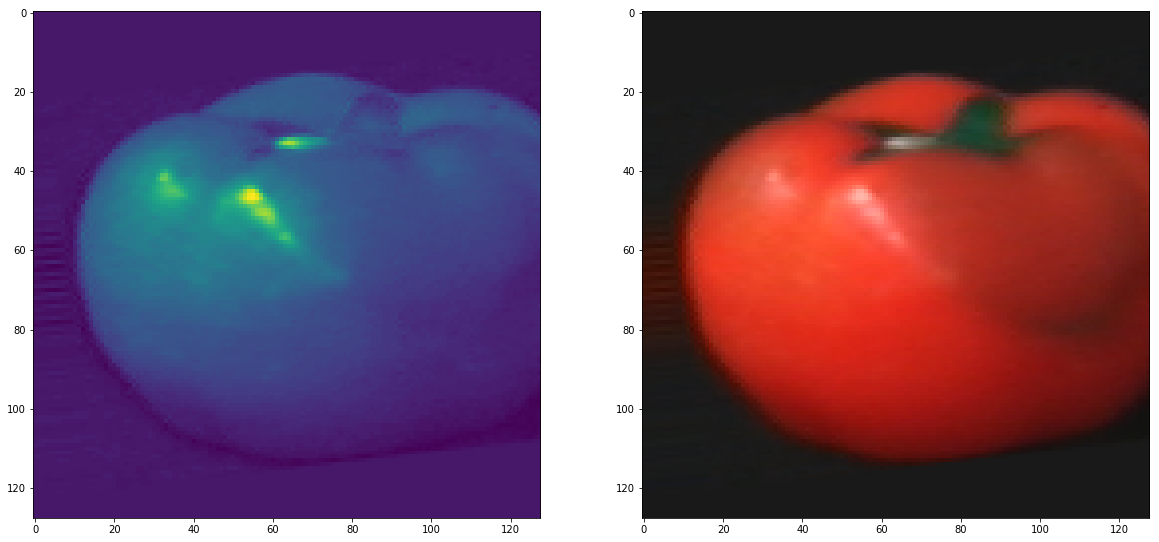

In [4]:
DATA_PATH = 'augmented_data/'

greyscale_data = np.array([[cv.imread(os.path.join(DATA_PATH, img), 0), int(img.split('_')[0][3:]) - 1] 
                            for img in os.listdir(DATA_PATH)])
color_data = np.array([[cv.imread(os.path.join(DATA_PATH, img)), int(img.split('_')[0][3:]) - 1] 
                        for img in os.listdir(DATA_PATH)])

greyscale_imgs, grayscale_labels = greyscale_data[:, 0], greyscale_data[:, 1]
color_imgs, color_labels = color_data[:, 0], color_data[:, 1]

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(greyscale_imgs[1160])
fig.add_subplot(1, 2, 2)
plt.imshow(color_imgs[1160])
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# split data
X_train_greyscale, X_test_greyscale, y_train_greyscale, y_test_greyscale = train_test_split(greyscale_imgs, 
                                                                           grayscale_labels, test_size=0.2)
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(color_imgs, 
                                                                            color_labels, test_size=0.2)

X_train_color = np.array([x/255 for x in X_train_color])
X_test_color = np.array([x/255 for x in X_test_color])

y_train_color = to_categorical(y_train_color)
y_test_color = to_categorical(y_test_color)

X_train_greyscale = np.array([x/255 for x in X_train_greyscale])
X_test_greyscale = np.array([x/255 for x in X_test_greyscale])

y_train_greyscale = to_categorical(y_train_greyscale)
y_test_greyscale = to_categorical(y_test_greyscale)

# Define neural network architecture

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense

def create_model(input_shape, kernel):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=kernel, strides=(1,1), padding='same', 
                     activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=kernel, strides=(1,1), padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=20, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta', metrics=['acc'])
    return model

# Training our model on RGB data

In [7]:
kernel = (3, 3)
img_shape = (128, 128, 3)

model = create_model(img_shape, kernel)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)      

In [8]:
model.fit(X_train_color, y_train_color, 
          batch_size=64, epochs=10, verbose=1)

model.save_weights('10_epochs_color.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
5671/5671 [==============================] - 239s 42ms/step - loss: 2.4450 - acc: 0.2329
Epoch 2/10
5671/5671 [==============================] - 250s 44ms/step - loss: 1.3545 - acc: 0.5392
Epoch 3/10
5671/5671 [==============================] - 245s 43ms/step - loss: 0.8532 - acc: 0.6944
Epoch 4/10
5671/5671 [==============================] - 254s 45ms/step - loss: 0.5851 - acc: 0.7768
Epoch 5/10
5671/5671 [==============================] - 265s 47ms/step - loss: 0.4848 - acc: 0.8200
Epoch 6/10
5671/5671 [==============================] - 274s 48ms/step - loss: 0.4120 - acc: 0.8459
Epoch 7/10
5671/5671 [==============================] - 248s 44ms/step - loss: 0.3556 - acc: 0.8653
Epoch 8/10
5671/5671 [==============================] - 240s 42ms/step - loss: 0.3413 - acc: 0.8709
Epoch 9/10
5671/5671 [==============================] - 240s 42ms/step - loss: 0.2902 - acc: 0.8900
Epoch 10/10
5671/5671 [=============================

In [9]:
score = model.evaluate(X_test_color, y_test_color, verbose=1)
score

1418/1418 [==============================] - 15s 11ms/step


[0.058366799685047946, 0.9809590973201693]

__loss__: 0.058
__accuracy__: 0.98
for RGB dataset

# Train our model on greyscale data

In [10]:
kernel = (3, 3)
img_shape = (128, 128, 1)

model_greyscale = create_model(img_shape, kernel)
model_greyscale.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               26214500  
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [16]:
X_train_greyscale = X_train_greyscale.reshape(X_train_greyscale.shape +(1,))
X_test_greyscale = X_test_greyscale.reshape(X_test_greyscale.shape +(1,))

model_greyscale.fit(X_train_greyscale, y_train_greyscale, 
          batch_size=64, epochs=10, verbose=1)

model_greyscale.save_weights('10_epochs_greyscale.h5')

Epoch 1/10
5671/5671 [==============================] - 239s 42ms/step - loss: 2.9648 - acc: 0.0801
Epoch 2/10
5671/5671 [==============================] - 235s 41ms/step - loss: 2.7224 - acc: 0.1307
Epoch 3/10
5671/5671 [==============================] - 235s 41ms/step - loss: 2.4932 - acc: 0.1864
Epoch 4/10
5671/5671 [==============================] - 233s 41ms/step - loss: 2.1688 - acc: 0.2666
Epoch 5/10
5671/5671 [==============================] - 232s 41ms/step - loss: 1.8837 - acc: 0.3548
Epoch 6/10
5671/5671 [==============================] - 233s 41ms/step - loss: 1.6745 - acc: 0.4142
Epoch 7/10
5671/5671 [==============================] - 233s 41ms/step - loss: 1.5248 - acc: 0.4606
Epoch 8/10
5671/5671 [==============================] - 222s 39ms/step - loss: 1.3336 - acc: 0.5354
Epoch 9/10
5671/5671 [==============================] - 220s 39ms/step - loss: 1.2116 - acc: 0.5592
Epoch 10/10
5671/5671 [==============================] - 223s 39ms/step - loss: 1.1409 - acc: 0.5920

In [17]:
score = model_greyscale.evaluate(X_test_greyscale, y_test_greyscale, verbose=1)
score

1418/1418 [==============================] - 13s 9ms/step


[0.8427795502967996, 0.715796897206219]

__loss__: 0.842
__accuracy__: 0.715
for greyscale dataset

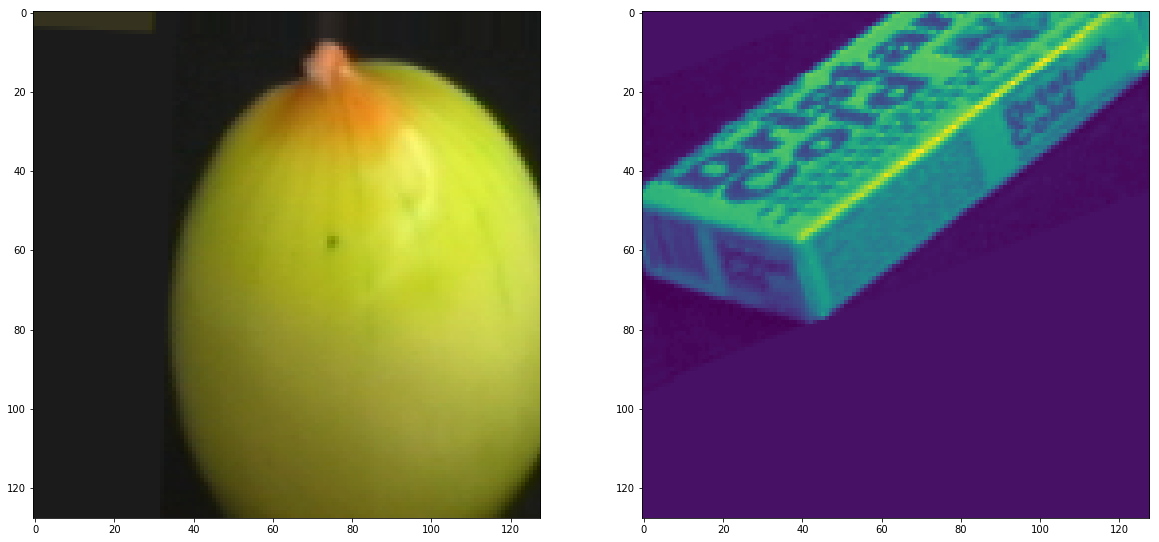

2obj
1obj


In [33]:
def predict(img, color=True):
    img = img/255
    img = img.reshape((1,) + img.shape)
    if color == True:
        return str(model.predict_classes(img, batch_size=1)[0] + 1) + 'obj'
    else:
        img = img.reshape(img.shape + (1,))
        return str(model_greyscale.predict_classes(img)[0] + 1) + 'obj'
    
img1 = cv.imread('augmented_data/obj2_0_228.png')
img2 = cv.imread('augmented_data/obj1_0_309.png', 0)

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img1)
fig.add_subplot(1, 2, 2)
plt.imshow(img2)
plt.show()

print(predict(img1))
print(predict(img2, color=False))